In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def decode(frame, bits = 1):
    frame = frame.flatten()
    frame = frame%(2**bits)
    number_of_images = convert_to_number(frame[0:4//bits])
    frame = frame[4//bits:]
    resolutions = []
    for i in range(0, number_of_images):
        resolutions.append((convert_to_number(frame[0//bits:12//bits], bits),
                            convert_to_number(frame[12//bits:24//bits], bits),
                            convert_to_number(frame[24//bits:26//bits], bits)))
        frame = frame[26//bits:]
    # print(resolutions)
    
    decoded_frames = []
    # Start extracting frames
    for resolution in resolutions:
        total_val = resolution[0]*resolution[1]*resolution[2]
        arr = []
        for i in range(0, total_val*8//bits, 8//bits):
            arr.append(convert_to_number(frame[i//bits:i+(8//bits)], bits))
        # print(len(arr))
        frame = frame[total_val*8//bits:]
        arr = np.array(arr)
        arr = np.reshape(arr, resolution)
        decoded_frames.append(arr)
    return decoded_frames


def encode(frame, img_list, bits = 1):
    frame_shape = frame.shape
    number_of_images = len(img_list)
    resolutions = []
    for img in img_list:
        resolutions.append(img.shape)
    frame = frame.flatten()

    # Check if encoding is possible
    total_res = 0
    for res in resolutions:
        total_res += res[0]*res[1]*res[2]*8//bits
    total_res += len(resolutions)*12//bits + number_of_images*4//bits
    if total_res < len(frame):
        print("Encoding is possible!")
    else:
        print("Encoding not possible!")
        return
    
    # Start the encoding process of images
    index = 0
    # Encode the number of images
    number_of_images = convert_to_binaryList(number_of_images,4)
    # print(number_of_images)
    for i in range(0,len(number_of_images), bits):
        frame[index] = get_bits(frame[index], number_of_images[i:i+bits], bits)
        index += 1
    print(number_of_images)
    # Encode the resolutions
    for res in resolutions:
        width = convert_to_binaryList(res[0],12)
        for i in range(0,len(width), bits):
            frame[index] = get_bits(frame[index], width[i:i+bits], bits)
            index += 1

        height = convert_to_binaryList(res[1],12)
        for i in range(0,len(height), bits):
            frame[index] = get_bits(frame[index], height[i:i+bits], bits)
            index += 1
        
        channel = convert_to_binaryList(res[2],2)
        for i in range(0,len(channel), bits):
            frame[index] = get_bits(frame[index], channel[i:i+bits], bits)
            index += 1
    
    # Encode the images
    for img in img_list:
        img = img.flatten()
        for value in img.tolist():
            value = convert_to_binaryList(value,8)
            for i in range(0,len(value), bits):
                frame[index] = get_bits(frame[index], value[i:i+bits], bits)
                index += 1
    return np.reshape(frame, frame_shape)
        

def get_bits(old_val, new_val, bits = 1):
    old_val = convert_to_binaryList(old_val)
    for i in range(0, bits):
    #    print(i)
       old_val[-i-1] = get_singular_bits(old_val[-i-1], new_val[-i-1])
    return convert_to_number(old_val, bits)
    

def get_singular_bits(old_val, new_val):
    if old_val%2 != new_val == 0:
        return old_val-1
    elif old_val%2 != new_val == 1:
        return old_val+1
    else:
        return old_val


def convert_to_number(arr, bits = 1):
    res = 0
    arr = np.flip(arr, axis = 0)
    for i in range(0, arr.shape[0]):
        res += arr[i]*((2**bits)**i)
    return res

def convert_to_binaryList(num, width = 12):
    res = []
    while(num > 0):
        res.append(num%2)
        num = num//2
    while(len(res) < width):
        res.append(0)
    res.reverse()
    return np.array(res)
    

In [36]:
get_bits(8, [0,1], 2)

[0 0 0 0 0 0 0 0 1 0 0 1]
[0 0 0 0 0 0 0 0 1 0 0 1]


65

In [3]:
small_img = cv2.imread("small_img.jpg")
small_img = cv2.resize(small_img, dsize=(500,500), interpolation=cv2.INTER_AREA)
big_img = cv2.imread("high_res.jpg")
encoded_image = encode(big_img, [small_img], 1)

Encoding is possible!
[0 0 0 1]


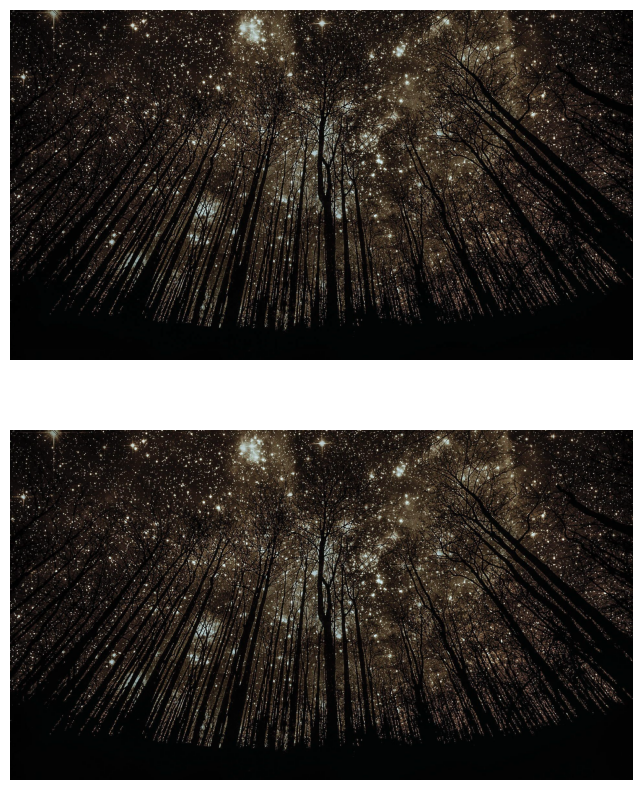

In [4]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.imshow(encoded_image)
plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(big_img)
plt.axis('off')

plt.show()

In [5]:
encoded_image.flatten()

array([8, 6, 4, ..., 2, 2, 2], dtype=uint8)

In [8]:
decoded_image = decode(encoded_image)

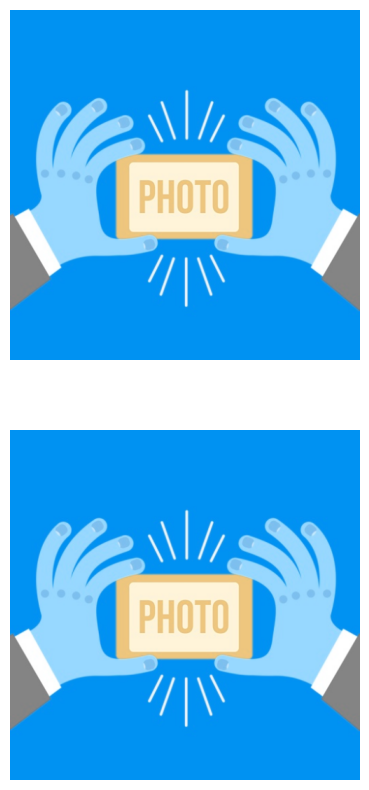

In [9]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.imshow(decoded_image[0])
plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(small_img)
plt.axis('off')

plt.show()